# Modeling #

## Import APIs ##

In [24]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import wfdb
import ast

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data ##

In [26]:
ptbxl_data = pd.read_csv('./cleaned_data/cleaned_ptbxl_metadata.csv', index_col='ecg_id')
normal_data = ptbxl_data[ptbxl_data['diagnostic_superclass'] == 'NORMAL']
abnormal_data = ptbxl_data[ptbxl_data['diagnostic_superclass'] == 'ABNORMAL']

### Metadata ###

In [27]:
normal_metadata = normal_data.loc[:, ['age', 'sex', 'device', 'validated_by_human']].copy()
abnormal_metadata = abnormal_data.loc[:, ['age', 'sex', 'device', 'validated_by_human']].copy()
print(f'Normal metadata shape: {normal_metadata.shape}')
print(f'Abnormal metadata shape: {abnormal_metadata.shape}')

Normal metadata shape: (9069, 4)
Abnormal metadata shape: (9069, 4)


### ECG Waveform data ###

In [5]:
def extract_ecg_data(data):
    new_data = []
    for idx in data.index:
        record_path = data.loc[idx]['filename_lr']
        waveform_df = pd.read_csv('./cleaned_data/waveform_data/' + record_path + '.csv', index_col='Time (s)')
        new_data.append(waveform_df)
    new_data = np.array(new_data)
    return new_data

In [6]:
normal_ecg_data = extract_ecg_data(normal_data)
abnormal_ecg_data = extract_ecg_data(abnormal_data)
print(f'Normal ECG data shape: {normal_ecg_data.shape}')
print(f'Abnormal ECG data shape: {abnormal_ecg_data.shape}')

Normal ECG data shape: (9069, 1000, 12)
Abnormal ECG data shape: (9069, 1000, 12)


In [7]:
# np.save("./cleaned_data/normal_ecg_data.npy", normal_ecg_data)
# np.save("./cleaned_data/abnormal_ecg_data.npy", abnormal_ecg_data)

In [28]:
normal_ecg_data = np.load("./cleaned_data/normal_ecg_data.npy")
abnormal_ecg_data = np.load("./cleaned_data/abnormal_ecg_data.npy")

## Train-test split ##

In [29]:
split_idx = int(normal_data.shape[0] * 0.8)

normal_ecg_train = normal_ecg_data[0:split_idx]
normal_ecg_test = normal_ecg_data[split_idx:]
print(f'Normal ECG train shape: {normal_ecg_train.shape}')
print(f'Normal ECG test shape: {normal_ecg_test.shape}')

abnormal_ecg_train = abnormal_ecg_data[0:split_idx]
abnormal_ecg_test = abnormal_ecg_data[split_idx:]
print(f'Abnormal ECG train shape: {abnormal_ecg_train.shape}')
print(f'Abnormal ECG test shape: {abnormal_ecg_test.shape}')

normal_metadata_train = normal_metadata[0:split_idx]
normal_metadata_test = normal_metadata[split_idx:]
print(f'Normal metadata train shape: {normal_metadata_train.shape}')
print(f'Normal metadata test shape: {normal_metadata_test.shape}')

abnormal_metadata_train = abnormal_metadata[0:split_idx]
abnormal_metadata_test = abnormal_metadata[split_idx:]
print(f'Abnormal metadata train shape: {abnormal_metadata_train.shape}')
print(f'Abnormal metadata test shape: {abnormal_metadata_test.shape}')

Normal ECG train shape: (7255, 1000, 12)
Normal ECG test shape: (1814, 1000, 12)
Abnormal ECG train shape: (7255, 1000, 12)
Abnormal ECG test shape: (1814, 1000, 12)
Normal metadata train shape: (7255, 4)
Normal metadata test shape: (1814, 4)
Abnormal metadata train shape: (7255, 4)
Abnormal metadata test shape: (1814, 4)


## Normalize ECG waveform data ##

In [30]:
def normalize_waveform(data):
    # Code generated from Bing Copilot
    normalized_data = np.empty_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            min_val = np.min(data[i, :, j])
            max_val = np.max(data[i, :, j])

            if max_val == min_val:
                normalized_data[i, :, j] = 0
            else:
                normalized_data[i, :, j] = (data[i, :, j] - min_val) / (max_val - min_val)
    return normalized_data

In [31]:
# Since normalization occurs only within each record, there will be no contamination from train data
std_normal_ecg_train = normalize_waveform(normal_ecg_train)
std_normal_ecg_test = normalize_waveform(normal_ecg_test)

std_abnormal_ecg_train = normalize_waveform(abnormal_ecg_train)
std_abnormal_ecg_test = normalize_waveform(abnormal_ecg_test)

## Normalize and one-hot encode metadata ##

In [32]:
def normalize_metadata(train_data, test_data):
    # Code generated from ChatGPT
    scaler_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    encoder_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler_transformer, ['age']),
            ('cat', encoder_transformer, ['sex', 'device', 'validated_by_human'])
        ])

    std_train_data = preprocessor.fit_transform(train_data).toarray()
    std_test_data = preprocessor.transform(test_data).toarray()
    
    return std_train_data, std_test_data

In [33]:
std_normal_metadata_train, std_normal_metadata_test = normalize_metadata(normal_metadata_train, normal_metadata_test)
std_abnormal_metadata_train, std_abnormal_metadata_test = normalize_metadata(abnormal_metadata_train, abnormal_metadata_test)

## Initialize Autoencoder Dataloaders ##

In [34]:
autoencoder_ecg_train_set = torch.from_numpy(std_normal_ecg_train).float()
autoencoder_metadata_train_set = torch.from_numpy(std_normal_metadata_train).float()

normal_ecg_test_set = torch.from_numpy(std_normal_ecg_test).float()
normal_metadata_test_set = torch.from_numpy(std_normal_metadata_test).float()

abnormal_ecg_test_set = torch.from_numpy(std_abnormal_ecg_test).float()
abnormal_metadata_test_set = torch.from_numpy(std_abnormal_metadata_test).float()

In [15]:
batch_size = 32

autoencoder_train_dataset = TensorDataset(autoencoder_ecg_train_set, autoencoder_metadata_train_set)
autoencoder_train_loader = DataLoader(autoencoder_train_dataset, batch_size=batch_size, shuffle=True)

normal_test_dataset = TensorDataset(normal_ecg_test_set, normal_metadata_test_set)
normal_test_loader = DataLoader(normal_test_dataset, batch_size=1, shuffle=False)

abnormal_test_dataset = TensorDataset(abnormal_ecg_test_set, abnormal_metadata_test_set)
abnormal_test_loader = DataLoader(abnormal_test_dataset, batch_size=1, shuffle=False)

## JeffNet: CNN autoencoder + LSTM metadata model ##

In [16]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=12,
                      out_channels=64,
                      kernel_size=3,
                      stride=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64,
                               out_channels=12,
                               kernel_size=3,
                               stride=1),
            nn.Sigmoid(),
            nn.Upsample(1000)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        encoded_output = self.encoder(x)
        decoded_output = self.decoder(encoded_output)
        return decoded_output.permute(0, 2, 1)

In [74]:
class MetadataLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(16, 128, batch_first=True)
        self.output_layer = nn.Linear(128, 12)
    
    def forward(self, x, h):
        lstm_outputs, h_n = self.lstm(x, h)
        outputs = self.output_layer(lstm_outputs.squeeze(dim=1))
        return outputs, h_n

In [75]:
class JeffNet(nn.Module):
    def __init__(self, cnn_autoencoder, lstm_model):
        super().__init__()
        self.cnn_autoencoder = cnn_autoencoder
        self.lstm_model = lstm_model
        self.fc = nn.Sequential(
            nn.Linear(24, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
        )
        
    def forward(self, ecg_data, metadata, hc):
        cnn_output = self.cnn_autoencoder(ecg_data)
        lstm_output, hc_n = self.lstm_model(metadata, hc)
        reshaped_lstm_output = lstm_output.unsqueeze(1).repeat(1, 1000, 1)
        combined_output = torch.cat((cnn_output, reshaped_lstm_output), dim=-1)
        output = self.fc(combined_output)

        return output, hc_n

### Training ###

In [76]:
def train_jeffnet(model, train_loader, criterion, optimizer, nepoch=40):
    model.train()
    for epoch in range(nepoch):
        num_layers = model.lstm_model.lstm.num_layers
        hidden_size = model.lstm_model.lstm.hidden_size
        h = torch.zeros(num_layers, hidden_size).to(device)
        c = torch.zeros(num_layers, hidden_size).to(device)
        
        for batch_ecg, batch_metadata in train_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            
            optimizer.zero_grad()
            reconstructed_data, (h, c) = model(ecg_data, metadata, (h.detach(), c.detach()))
            loss = criterion(reconstructed_data, ecg_data)
            loss.backward()
            optimizer.step()
            
        if not (epoch + 1) % 5:
            print(f"Epoch [{epoch+1}/{nepoch}], Loss: {loss.item()}")

In [77]:
cnn_autoencoder_model = CNNAutoencoder()
lstm_metadata_model = MetadataLSTM()

jeffnet_model = JeffNet(cnn_autoencoder_model, lstm_metadata_model)
jeffnet_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(jeffnet_model.parameters(), lr=5e-3)

train_jeffnet(jeffnet_model, autoencoder_train_loader, criterion, optimizer)

Epoch [5/40], Loss: 0.0005986391333863139
Epoch [10/40], Loss: 0.0002942043065559119
Epoch [15/40], Loss: 0.00019704482110682875
Epoch [20/40], Loss: 0.00010803938494063914
Epoch [25/40], Loss: 0.00012246932601556182
Epoch [30/40], Loss: 0.0003693228354677558
Epoch [35/40], Loss: 0.00019158574286848307
Epoch [40/40], Loss: 0.00013528727868106216


In [78]:
torch.save(jeffnet_model.state_dict(), "./models/combinedModel1k_v1.pth")

### Testing ###

In [79]:
def test_jeffnet(model, test_loader, criterion, percentile):
    num_layers = model.lstm_model.lstm.num_layers
    hidden_size = model.lstm_model.lstm.hidden_size
    h_0 = torch.zeros(num_layers, hidden_size).to(device)
    c_0 = torch.zeros(num_layers, hidden_size).to(device)
    
    total_loss = 0
    errors = []
    model.eval()
    with torch.no_grad():
        for batch_ecg, batch_metadata in test_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            
            reconstructed_data, _ = model(ecg_data, metadata, (h_0, c_0))
            
            loss = criterion(reconstructed_data, ecg_data).reshape(1, -1)
            total_loss += loss.mean()
            
            new_errors = loss.tolist()[0]
            errors.extend(new_errors)
    
    avg_error = total_loss / len(test_loader)
    threshold = np.percentile(errors, percentile)
    
    return avg_error, threshold

In [80]:
def detect_anomalies(original_ecg, reconstructed_ecg, criterion, threshold):
    reconstruction_errors = criterion(original_ecg, reconstructed_ecg)
    anomalies = np.where(reconstruction_errors > threshold)
    return anomalies

In [81]:
def get_jeffnet_anomalies(model, test_loader, criterion, threshold):
    num_layers = model.lstm_model.lstm.num_layers
    hidden_size = model.lstm_model.lstm.hidden_size
    h_0 = torch.zeros(num_layers, hidden_size).to(device)
    c_0 = torch.zeros(num_layers, hidden_size).to(device)
    
    anomalies = []
    model.eval()
    with torch.no_grad():
        for batch_ecg, batch_metadata in test_loader:            
            ecg_input = batch_ecg[0].unsqueeze(0).to(device)
            metadata_input = batch_metadata[0].unsqueeze(0).to(device)
            
            prediction, _ = model(ecg_input.to(device), metadata_input.to(device), (h_0, c_0))
            
            num_anomalies = 0
            for lead_idx in range(12):
                original_ecg = ecg_input[0, :, lead_idx].cpu()
                reconstructed_ecg = prediction[0, :, lead_idx].cpu()

                anomalies_cond = detect_anomalies(original_ecg, reconstructed_ecg, criterion, threshold)
                anomalies_in_ecg = original_ecg[anomalies_cond]
                num_anomalies += len(anomalies_in_ecg)
            anomalies.append(num_anomalies)

    return anomalies

In [82]:
def print_stats(reconstruction_error, threshold, anomalies):
    print(f'Average reconstruction error: {reconstruction_error:.5f}')
    print('Anomalies:')
    print(f'Mean: {sum(anomalies) / len(anomalies)}')
    print(f'Max: {np.percentile(anomalies, 100)}')
    print(f'Upper quartile: {np.percentile(anomalies, 75)}')
    print(f'Median: {np.percentile(anomalies, 50)}')
    print(f'Lower quartile: {np.percentile(anomalies, 25)}')
    print(f'Min: {np.percentile(anomalies, 0)}\n')

In [83]:
criterion = nn.MSELoss(reduction='none')
percentile = 99

reconstruction_error, threshold = test_jeffnet(jeffnet_model, normal_test_loader, criterion, percentile)
anomalies = get_jeffnet_anomalies(jeffnet_model, normal_test_loader, criterion, threshold)
print(f'{percentile}th percentile threshold: {threshold}\n')
print('Normal test loader:')
print_stats(reconstruction_error, threshold, anomalies)

reconstruction_error, _ = test_jeffnet(jeffnet_model, abnormal_test_loader, criterion, percentile)
anomalies = get_jeffnet_anomalies(jeffnet_model, abnormal_test_loader, criterion, threshold)
print('Abnormal test loader:')
print_stats(reconstruction_error, threshold, anomalies)

99th percentile threshold: 0.0007054242654703615

Normal test loader:
Average reconstruction error: 0.00010
Anomalies:
Mean: 120.0
Max: 3683.0
Upper quartile: 127.0
Median: 90.0
Lower quartile: 68.0
Min: 31.0

Abnormal test loader:
Average reconstruction error: 0.00019
Anomalies:
Mean: 374.04796030871006
Max: 5656.0
Upper quartile: 389.75
Median: 170.5
Lower quartile: 98.0
Min: 29.0



### Visualization ###

In [72]:
def visualize(model, ecg_input, metadata_input, criterion, threshold, show_reconstruction=False):
    lead_vals = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    time = np.arange(0, 1000) / 100

    model.eval()
    with torch.no_grad():
        num_layers = model.lstm_model.lstm.num_layers
        hidden_size = model.lstm_model.lstm.hidden_size
        h_0 = torch.zeros(num_layers, hidden_size).to(device)
        c_0 = torch.zeros(num_layers, hidden_size).to(device)

        num_anomalies = 0
        prediction, _ = model(ecg_input.to(device), metadata_input.to(device), (h_0, c_0))

        fig, axs = plt.subplots(6, 2, figsize=(15, 20))
        for i in range(6):
            for j in range(2):
                lead_idx = i * 2 + j
                lead_val = lead_vals[lead_idx]
                original_ecg = ecg_input[0, :, lead_idx].cpu()
                reconstructed_ecg = prediction[0, :, lead_idx].cpu()
                anomalies_cond = detect_anomalies(original_ecg, reconstructed_ecg, criterion, threshold)
                anomalies_in_ecg = original_ecg[anomalies_cond]
                num_anomalies += len(anomalies_in_ecg)
                axs[i, j].scatter(time[anomalies_cond], anomalies_in_ecg, color='red', label='Anomalies')
                axs[i, j].plot(time, original_ecg.detach().numpy(), label='Original')
                if show_reconstruction:
                    axs[i, j].plot(time, reconstructed_ecg.detach().numpy(), label='Reconstructed')
                axs[i, j].set_xlabel('Time (s)')
                axs[i, j].set_ylabel('Normalized ECG Reading')
                axs[i, j].set_title(f'Lead {lead_val}')
                axs[i, j].legend()

        plt.tight_layout()
        plt.show()
        print(f'Total number of anomalies: {num_anomalies}')

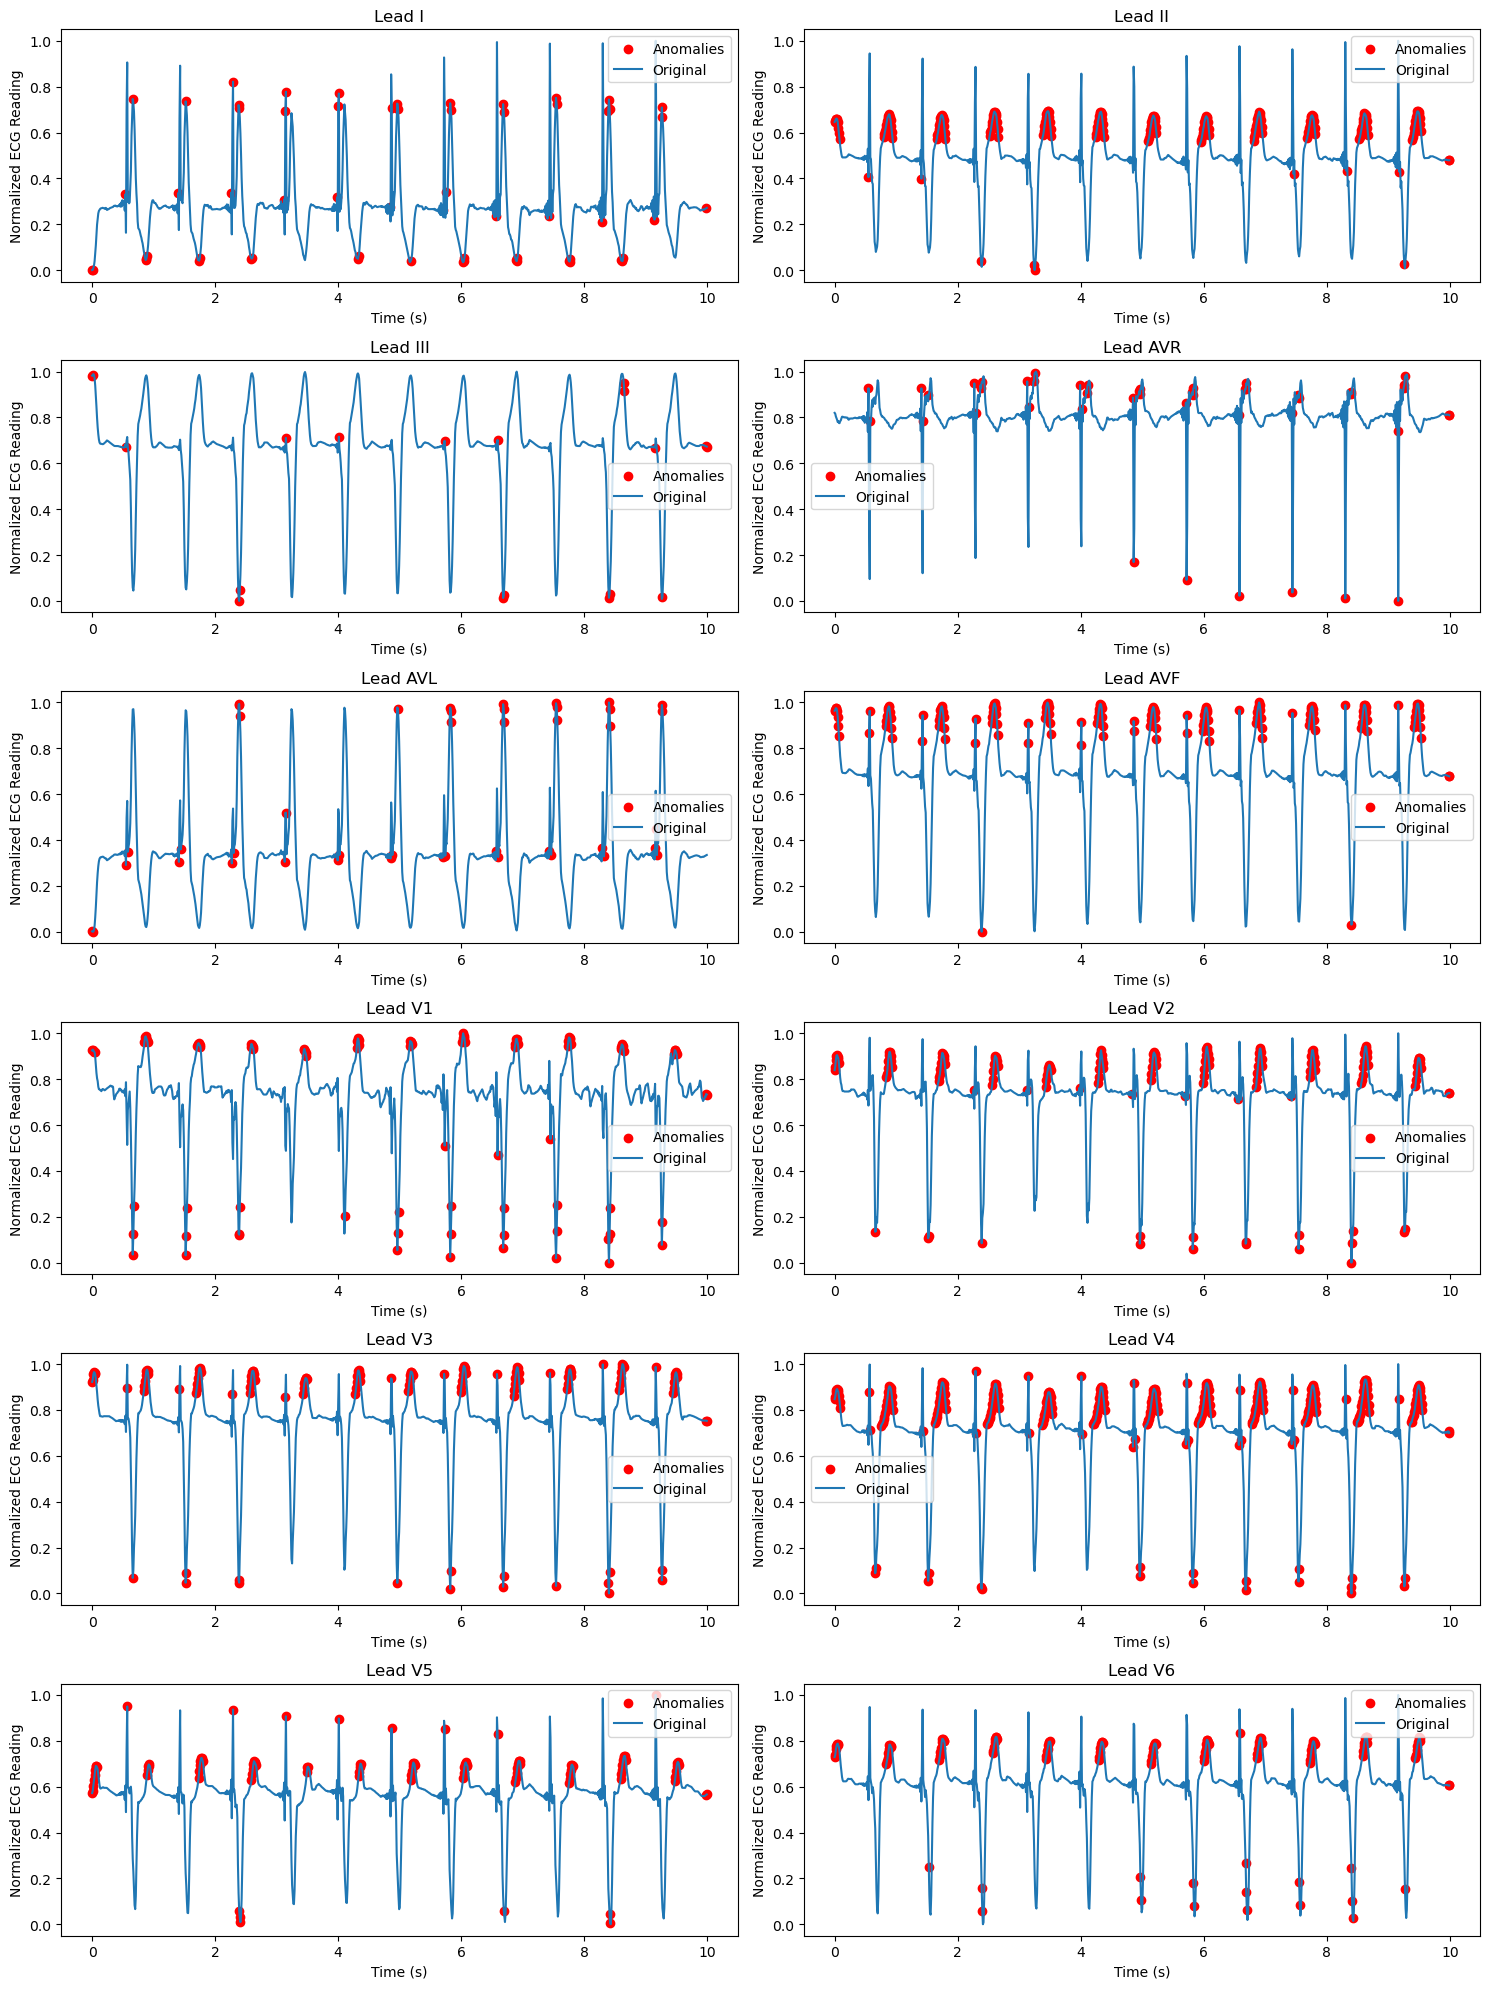

Total number of anomalies: 1371


In [73]:
criterion = nn.MSELoss(reduction='none')

for batch_ecg, batch_metadata in abnormal_test_loader:
    single_abnormal_ecg_data = batch_ecg[0].unsqueeze(0).to(device)  # Move to device
    single_abnormal_metadata = batch_metadata[0].unsqueeze(0).to(device)
    break

visualize(jeffnet_model, single_abnormal_ecg_data, single_abnormal_metadata, criterion, threshold)

## JamesNet: CNN autoencoder + MLP metadata model ##

In [29]:
class MetadataMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, 12)
        )
    
    def forward(self, x):
        return self.layers(x)

In [30]:
class JamesNet(nn.Module):
    def __init__(self, cnn_autoencoder, mlp_model):
        super().__init__()
        self.cnn_autoencoder = cnn_autoencoder
        self.mlp_model = mlp_model
        self.fc = nn.Sequential(
            nn.Linear(24, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
        )
        
    def forward(self, ecg_data, metadata):
        cnn_output = self.cnn_autoencoder(ecg_data)
        mlp_output = self.mlp_model(metadata)
        reshaped_mlp_output = mlp_output.unsqueeze(1).repeat(1, 1000, 1)
        combined_output = torch.cat((cnn_output, reshaped_mlp_output), dim=-1)
        output = self.fc(combined_output)

        return output

### Training ###

In [31]:
def train_jamesnet(model, train_loader, criterion, optimizer, nepoch=40):
    model.train()
    for epoch in range(nepoch):        
        for batch_ecg, batch_metadata in train_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            
            optimizer.zero_grad()
            reconstructed_data= model(ecg_data, metadata)
            loss = criterion(reconstructed_data, ecg_data)
            loss.backward()
            optimizer.step()
            
        if not (epoch + 1) % 5:
            print(f"Epoch [{epoch+1}/{nepoch}], Loss: {loss.item()}")

In [32]:
cnn_autoencoder_model = CNNAutoencoder()
mlp_metadata_model = MetadataMLP()

jamesnet_model = JamesNet(cnn_autoencoder_model, mlp_metadata_model)
jamesnet_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(jamesnet_model.parameters(), lr=5e-3)

train_jamesnet(jamesnet_model, autoencoder_train_loader, criterion, optimizer)

Epoch [5/40], Loss: 0.0012338022934272885
Epoch [10/40], Loss: 0.0002843601687345654
Epoch [15/40], Loss: 0.00017300093895755708
Epoch [20/40], Loss: 0.00015840682317502797
Epoch [25/40], Loss: 0.00019069371046498418
Epoch [30/40], Loss: 0.00014307374658528715
Epoch [35/40], Loss: 8.800832438282669e-05
Epoch [40/40], Loss: 7.478061161236838e-05


### Testing ###

In [33]:
def test_jamesnet(model, test_loader, criterion, percentile):
    total_loss = 0
    errors = []
    model.eval()
    with torch.no_grad():
        for batch_ecg, batch_metadata in test_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            
            reconstructed_data = model(ecg_data, metadata)
            
            loss = criterion(reconstructed_data, ecg_data).reshape(1, -1)
            total_loss += loss.mean()
            
            new_errors = loss.tolist()[0]
            errors.extend(new_errors)
    
    avg_error = total_loss / len(test_loader)
    threshold = np.percentile(errors, percentile)
    
    return avg_error, threshold

In [34]:
def get_jamesnet_anomalies(model, test_loader, criterion, threshold):
    anomalies = []
    model.eval()
    with torch.no_grad():
        for batch_ecg, batch_metadata in test_loader:            
            ecg_input = batch_ecg[0].unsqueeze(0).to(device)
            metadata_input = batch_metadata[0].unsqueeze(0).to(device)
            
            prediction = model(ecg_input.to(device), metadata_input.to(device))
            
            num_anomalies = 0
            for lead_idx in range(12):
                original_ecg = ecg_input[0, :, lead_idx].cpu()
                reconstructed_ecg = prediction[0, :, lead_idx].cpu()

                anomalies_cond = detect_anomalies(original_ecg, reconstructed_ecg, criterion, threshold)
                anomalies_in_ecg = original_ecg[anomalies_cond]
                num_anomalies += len(anomalies_in_ecg)
            anomalies.append(num_anomalies)

    return anomalies

In [35]:
criterion = nn.MSELoss(reduction='none')
percentile = 99

reconstruction_error, threshold = test_jamesnet(jamesnet_model, normal_test_loader, criterion, percentile)
anomalies = get_jamesnet_anomalies(jamesnet_model, normal_test_loader, criterion, threshold)
print(f'{percentile}th percentile threshold: {threshold}\n')
print('Normal test loader:')
print_stats(reconstruction_error, threshold, anomalies)

reconstruction_error, _ = test_jamesnet(jamesnet_model, abnormal_test_loader, criterion, percentile)
anomalies = get_jamesnet_anomalies(jamesnet_model, abnormal_test_loader, criterion, threshold)
print('Abnormal test loader:')
print_stats(reconstruction_error, threshold, anomalies)

99th percentile threshold: 0.0007260681333718874

Normal test loader:
Average reconstruction error: 0.00011
Anomalies:
Mean: 120.0
Max: 6127.0
Upper quartile: 122.0
Median: 82.0
Lower quartile: 63.0
Min: 33.0

Abnormal test loader:
Average reconstruction error: 0.00019
Anomalies:
Mean: 368.05953693495036
Max: 5517.0
Upper quartile: 401.5
Median: 169.5
Lower quartile: 92.25
Min: 32.0



# Computational Experiment #1: Transfer Learning #

## Prepare datasets ##

In [36]:
# ECG data
combined_ecg_train = np.concatenate((normal_ecg_train, abnormal_ecg_train), axis=0)
combined_ecg_test = np.concatenate((normal_ecg_test, abnormal_ecg_test), axis=0)
print(f'Combined ECG train set shape: {combined_ecg_train.shape}')
print(f'Combined ECG test set shape: {combined_ecg_test.shape}\n')

# Metadata
combined_metadata_train = pd.concat([normal_metadata_train, abnormal_metadata_train], axis=0)
combined_metadata_test = pd.concat([normal_metadata_test, abnormal_metadata_test], axis=0)
print(f'Combined metadata train set shape: {combined_metadata_train.shape}')
print(f'Combined metadata test set shape: {combined_metadata_test.shape}\n')

# Labels - 1 is normal, 0 is abnormal
train_set_size = normal_ecg_train.shape[0]
test_set_size = normal_ecg_test.shape[0]
labels_train = np.concatenate((np.ones(train_set_size), np.zeros(train_set_size)))
labels_test = np.concatenate((np.ones(test_set_size), np.zeros(test_set_size)))
print(f'Labels train set shape: {labels_train.shape}')
print(f'Labels test set shape: {labels_test.shape}')

Combined ECG train set shape: (14510, 1000, 12)
Combined ECG test set shape: (3628, 1000, 12)

Combined metadata train set shape: (14510, 4)
Combined metadata test set shape: (3628, 4)

Labels train set shape: (14510,)
Labels test set shape: (3628,)


## Normalize and one-hot encode ##

In [37]:
std_combined_ecg_train = normalize_waveform(combined_ecg_train)
std_combined_ecg_test = normalize_waveform(combined_ecg_test)

std_combined_metadata_train, std_combined_metadata_test = normalize_metadata(combined_metadata_train, combined_metadata_test)

## Initialize DataLoaders ##

In [38]:
classifier_ecg_train_set = torch.from_numpy(std_combined_ecg_train).float()
classifier_ecg_test_set = torch.from_numpy(std_combined_ecg_test).float()

classifier_metadata_train_set = torch.from_numpy(std_combined_metadata_train).float()
classifier_metadata_test_set = torch.from_numpy(std_combined_metadata_test).float()

classifier_labels_train_set = torch.from_numpy(labels_train).float()
classifier_labels_test_set = torch.from_numpy(labels_test).float()

In [39]:
batch_size = 64

classifier_train_dataset = TensorDataset(classifier_ecg_train_set,
                                         classifier_metadata_train_set,
                                         classifier_labels_train_set)
classifier_train_loader = DataLoader(classifier_train_dataset, batch_size=batch_size, shuffle=True)

classifier_test_dataset = TensorDataset(classifier_ecg_test_set,
                                         classifier_metadata_test_set,
                                         classifier_labels_test_set)
classifier_test_loader = DataLoader(classifier_test_dataset, batch_size=1, shuffle=False)

## Classifier Model ##

In [40]:
class TransferLearningClassifier(nn.Module):
    def __init__(self, combinedModel):
        super(TransferLearningClassifier, self).__init__()
        
        encoder = combinedModel.cnn_autoencoder.encoder
        mlp = combinedModel.mlp_model
        
        # Freeze the encoder and LSTM weights
        for param in encoder.parameters():
            param.requires_grad = False
        for param in mlp.parameters():
            param.requires_grad = False
            
        self.encoder = encoder
        self.mlp_model = mlp
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(998 * 76, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
        
    def forward(self, ecg_data, metadata):
        ecg_data = ecg_data.permute(0, 2, 1)
        
        cnn_output = self.encoder(ecg_data).permute(0, 2, 1)
        mlp_output = self.mlp_model(metadata)
        reshaped_mlp_output = mlp_output.unsqueeze(1).repeat(1, 998, 1)
        
        combined_output = torch.cat((cnn_output, reshaped_mlp_output), dim=-1)
        output = self.fc(combined_output)
        return output

## Training ##

In [41]:
def train_classifier(model, train_loader, criterion, optimizer, nepoch=10, l2_lambda=1e-5):    
    for epoch in range(nepoch):
        for batch_ecg, batch_metadata, batch_labels in train_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            labels = batch_labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            predictions = model(ecg_data, metadata)
            
            l2_reg = torch.tensor(0.).to(device)
            for param in model.fc.parameters():
                l2_reg += torch.norm(param)
            
            loss = criterion(predictions, labels) + l2_lambda * l2_reg
            loss.backward()
            optimizer.step()
            
        print(f"Epoch [{epoch+1}/{nepoch}], Loss: {loss.item()}")

In [42]:
tl_classifier = TransferLearningClassifier(jamesnet_model)
tl_classifier.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, tl_classifier.parameters()), lr=2e-5)

train_classifier(tl_classifier, classifier_train_loader, criterion, optimizer)

Epoch [1/10], Loss: 0.6297567486763
Epoch [2/10], Loss: 0.551247239112854
Epoch [3/10], Loss: 0.6448603272438049
Epoch [4/10], Loss: 0.5311311483383179
Epoch [5/10], Loss: 0.5649816393852234
Epoch [6/10], Loss: 0.627669632434845
Epoch [7/10], Loss: 0.48081231117248535
Epoch [8/10], Loss: 0.5188197493553162
Epoch [9/10], Loss: 0.6041002869606018
Epoch [10/10], Loss: 0.5193297266960144


In [43]:
# torch.save(tl_classifier.state_dict(), "./models/tl_classifier_1k_v3.pth")

## Testing ##

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score

def test_classifier(model, test_loader):
    all_predicted = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch_ecg, batch_metadata, batch_labels in test_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            labels = batch_labels.to(device).float().unsqueeze(1)
            
            outputs = model(ecg_data, metadata)
            predicted = (outputs > 0.5).float()
            
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predicted)
    print(f'Transfer learning classifier test accuracy: {accuracy:.3f}')
    print(f'Confusion matrix:\n{confusion_matrix(all_labels, all_predicted)}')

In [45]:
test_classifier(tl_classifier, classifier_test_loader)

Transfer learning classifier test accuracy: 0.684
Confusion matrix:
[[1271  543]
 [ 605 1209]]


# Computational Experiment #2: TCN Autoencoder #

In [46]:
num_unique_devices = ptbxl_data['device'].nunique()
print(f"Number of unique devices: {num_unique_devices}")

Number of unique devices: 11


In [35]:
batch_size = 64

autoencoder_train_dataset = TensorDataset(autoencoder_ecg_train_set, autoencoder_metadata_train_set)
autoencoder_train_loader = DataLoader(autoencoder_train_dataset, batch_size=batch_size, shuffle=True)

normal_test_dataset = TensorDataset(normal_ecg_test_set, normal_metadata_test_set)
normal_test_loader = DataLoader(normal_test_dataset, batch_size=1, shuffle=False)

abnormal_test_dataset = TensorDataset(abnormal_ecg_test_set, abnormal_metadata_test_set)
abnormal_test_loader = DataLoader(abnormal_test_dataset, batch_size=1, shuffle=False)

In [38]:
from pytorch_tcn import TCN
num_unique_devices = ptbxl_data['device'].nunique()
class TCNAutoencoder(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size, dropout, metadata_dims):
        super(TCNAutoencoder, self).__init__()
        self.encoder = TCN(
            num_inputs=num_inputs,
            num_channels=num_channels,
            kernel_size=kernel_size,
            dropout=dropout,
            causal=True,
        )
        self.age_embedding = nn.Linear(1, metadata_dims[0])  # Age is a single value
        self.sex_embedding = nn.Linear(2, metadata_dims[1])  # Sex is one-hot encoded (2 columns)
        self.device_embedding = nn.Linear(num_unique_devices, metadata_dims[2]) #one hot (11 cols)
        self.validated_embedding = nn.Linear(2, metadata_dims[3]) #one hot (2 cols)
        
        decoder_input_dim = num_channels[-1] + sum(metadata_dims)
        self.decoder = TCN(
            num_inputs=decoder_input_dim,
            num_channels=num_channels[::-1],
            kernel_size=kernel_size,
            dropout=dropout,    
            causal=True,
            output_projection=num_inputs,
        )
        
    def forward(self, x, metadata):
        encoded = self.encoder(x)
        
        age_emb = self.age_embedding(metadata[:, 0].unsqueeze(1))
        sex_emb = self.sex_embedding(metadata[:, 1:3])
        device_emb = self.device_embedding(metadata[:, 3:-2])
        validated_emb = self.validated_embedding(metadata[:, -2:])
        
        metadata_emb = torch.cat([age_emb, sex_emb, device_emb, validated_emb], dim=-1)
        metadata_emb = metadata_emb.unsqueeze(2).expand(-1, -1, encoded.size(2))
        
        concatenated = torch.cat([encoded, metadata_emb], dim=1)
        decoded = self.decoder(concatenated)
        return decoded

In [48]:
batch_size = 64
num_inputs = 12  # Assuming 12 input channels in the ECG data
num_channels = [32, 64, 128]  # Example number of channels in each residual block of the encoder
kernel_size = 3  # Example kernel size for the TCN layers
dropout = 0.2  # Example dropout rate
metadata_dims = [10, 5, 20, 5]  # Example embedding dimensions for age, sex, and device, and validated

print(std_abnormal_metadata_train.shape)
assert num_unique_devices == std_abnormal_metadata_train.shape[1] - 5, "Number of unique devices should match the number of device columns in metadata"

model = TCNAutoencoder(num_inputs, num_channels, kernel_size, dropout, metadata_dims)

model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)
num_epochs = 15

(7255, 16)


In [49]:

for epoch in range(num_epochs):
    for batch_data, batch_metadata in autoencoder_train_loader:
        ecg_data = batch_data.to(device).permute(0, 2, 1).float()
        batch_metadata = batch_metadata.to(device).float()
        
        
        optimizer.zero_grad()
        reconstructed_data = model(ecg_data, batch_metadata)
        loss = criterion(reconstructed_data, ecg_data)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/10], Loss: 0.0042
Epoch [2/10], Loss: 0.0045
Epoch [3/10], Loss: 0.0046
Epoch [4/10], Loss: 0.0059
Epoch [5/10], Loss: 0.0047
Epoch [6/10], Loss: 0.0045
Epoch [7/10], Loss: 0.0056
Epoch [8/10], Loss: 0.0070
Epoch [9/10], Loss: 0.0060
Epoch [10/10], Loss: 0.0050


In [39]:
#reinit model
batch_size = 64
num_inputs = 12  # Assuming 12 input channels in the ECG data
num_channels = [32, 64, 128]  # Example number of channels in each residual block of the encoder
kernel_size = 4  # Example kernel size for the TCN layers
dropout = 0.2  # Example dropout rate
metadata_dims = [10, 5, 20, 5]  # Example embedding dimensions for age, sex, and device, and validated

model = TCNAutoencoder(num_inputs, num_channels, kernel_size, dropout, metadata_dims)
model.load_state_dict(torch.load("./models/tcn.pth"))
model.to(device)

criterion = nn.MSELoss()

RuntimeError: Error(s) in loading state_dict for TCNAutoencoder:
	size mismatch for encoder.network.0.conv1.buffer: copying a param with shape torch.Size([1, 12, 3]) from checkpoint, the shape in current model is torch.Size([1, 12, 2]).
	size mismatch for encoder.network.0.conv1.parametrizations.weight.original1: copying a param with shape torch.Size([32, 12, 4]) from checkpoint, the shape in current model is torch.Size([32, 12, 3]).
	size mismatch for encoder.network.0.conv2.buffer: copying a param with shape torch.Size([1, 32, 3]) from checkpoint, the shape in current model is torch.Size([1, 32, 2]).
	size mismatch for encoder.network.0.conv2.parametrizations.weight.original1: copying a param with shape torch.Size([32, 32, 4]) from checkpoint, the shape in current model is torch.Size([32, 32, 3]).
	size mismatch for encoder.network.1.conv1.buffer: copying a param with shape torch.Size([1, 32, 6]) from checkpoint, the shape in current model is torch.Size([1, 32, 4]).
	size mismatch for encoder.network.1.conv1.parametrizations.weight.original1: copying a param with shape torch.Size([64, 32, 4]) from checkpoint, the shape in current model is torch.Size([64, 32, 3]).
	size mismatch for encoder.network.1.conv2.buffer: copying a param with shape torch.Size([1, 64, 6]) from checkpoint, the shape in current model is torch.Size([1, 64, 4]).
	size mismatch for encoder.network.1.conv2.parametrizations.weight.original1: copying a param with shape torch.Size([64, 64, 4]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for encoder.network.2.conv1.buffer: copying a param with shape torch.Size([1, 64, 12]) from checkpoint, the shape in current model is torch.Size([1, 64, 8]).
	size mismatch for encoder.network.2.conv1.parametrizations.weight.original1: copying a param with shape torch.Size([128, 64, 4]) from checkpoint, the shape in current model is torch.Size([128, 64, 3]).
	size mismatch for encoder.network.2.conv2.buffer: copying a param with shape torch.Size([1, 128, 12]) from checkpoint, the shape in current model is torch.Size([1, 128, 8]).
	size mismatch for encoder.network.2.conv2.parametrizations.weight.original1: copying a param with shape torch.Size([128, 128, 4]) from checkpoint, the shape in current model is torch.Size([128, 128, 3]).
	size mismatch for decoder.network.0.conv1.buffer: copying a param with shape torch.Size([1, 168, 3]) from checkpoint, the shape in current model is torch.Size([1, 168, 2]).
	size mismatch for decoder.network.0.conv1.parametrizations.weight.original1: copying a param with shape torch.Size([128, 168, 4]) from checkpoint, the shape in current model is torch.Size([128, 168, 3]).
	size mismatch for decoder.network.0.conv2.buffer: copying a param with shape torch.Size([1, 128, 3]) from checkpoint, the shape in current model is torch.Size([1, 128, 2]).
	size mismatch for decoder.network.0.conv2.parametrizations.weight.original1: copying a param with shape torch.Size([128, 128, 4]) from checkpoint, the shape in current model is torch.Size([128, 128, 3]).
	size mismatch for decoder.network.1.conv1.buffer: copying a param with shape torch.Size([1, 128, 6]) from checkpoint, the shape in current model is torch.Size([1, 128, 4]).
	size mismatch for decoder.network.1.conv1.parametrizations.weight.original1: copying a param with shape torch.Size([64, 128, 4]) from checkpoint, the shape in current model is torch.Size([64, 128, 3]).
	size mismatch for decoder.network.1.conv2.buffer: copying a param with shape torch.Size([1, 64, 6]) from checkpoint, the shape in current model is torch.Size([1, 64, 4]).
	size mismatch for decoder.network.1.conv2.parametrizations.weight.original1: copying a param with shape torch.Size([64, 64, 4]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for decoder.network.2.conv1.buffer: copying a param with shape torch.Size([1, 64, 12]) from checkpoint, the shape in current model is torch.Size([1, 64, 8]).
	size mismatch for decoder.network.2.conv1.parametrizations.weight.original1: copying a param with shape torch.Size([32, 64, 4]) from checkpoint, the shape in current model is torch.Size([32, 64, 3]).
	size mismatch for decoder.network.2.conv2.buffer: copying a param with shape torch.Size([1, 32, 12]) from checkpoint, the shape in current model is torch.Size([1, 32, 8]).
	size mismatch for decoder.network.2.conv2.parametrizations.weight.original1: copying a param with shape torch.Size([32, 32, 4]) from checkpoint, the shape in current model is torch.Size([32, 32, 3]).

In [52]:
def test_model(model, test_loader, criterion, percentile):
   
    total_loss = 0
    errors = []
    model.eval()
    with torch.no_grad():
        for batch_ecg, batch_metadata in test_loader:
            ecg_data = batch_ecg.to(device).permute(0, 2, 1).float()
            metadata = batch_metadata.to(device).float()
            
            reconstructed_data = model(ecg_data, metadata)
            
            loss = criterion(reconstructed_data, ecg_data).reshape(1, -1)
            total_loss += loss.mean().item()
            
            new_errors = loss.tolist()[0]
            errors.extend(new_errors)
    
    avg_error = total_loss / len(test_loader)
    threshold = np.percentile(errors, percentile)
    
    return avg_error, threshold

In [53]:
test_model(model, normal_test_loader, criterion, 99)

(0.005368615718314048, 0.017896697986870977)

In [54]:
def detect_anomalies(original_ecg, reconstructed_ecg, criterion, threshold):
    reconstruction_errors = criterion(original_ecg, reconstructed_ecg)
    anomalies = np.where(reconstruction_errors > threshold)
    return anomalies


def get_anomalies_list(model, test_loader, criterion, threshold):
    anomalies = []
    model.eval()
    with torch.no_grad():
        for batch_ecg, batch_metadata in test_loader:            
            ecg_input = batch_ecg.to(device).permute(0, 2, 1).float()
            metadata_input = batch_metadata[0].unsqueeze(0).to(device)
            
            prediction = model(ecg_input.to(device), metadata_input.to(device))
            
            num_anomalies = 0
            for lead_idx in range(12):
                original_ecg = ecg_input[0, :, lead_idx].cpu()
                reconstructed_ecg = prediction[0, :, lead_idx].cpu()

                anomalies_cond = detect_anomalies(original_ecg, reconstructed_ecg, criterion, threshold)
                anomalies_in_ecg = original_ecg[anomalies_cond]
                num_anomalies += len(anomalies_in_ecg)
            anomalies.append(num_anomalies)

    return anomalies

In [55]:
criterion = nn.MSELoss(reduction='none')
percentile = 99

reconstruction_error, threshold = test_model(model, normal_test_loader, criterion, percentile)
anomalies = get_anomalies_list(model, normal_test_loader, criterion, threshold)
print('Normal test loader:')
print(f'Average reconstruction error: {reconstruction_error}')
print(f'{percentile}th percentile threshold: {threshold}')
print(f'Mean anomalies: {sum(anomalies) / len(anomalies)}')
print(f'Max anomalies: {np.percentile(anomalies, 100)}')
print(f'Min anomalies: {np.percentile(anomalies, 0)}')
print(f'Median anomalies: {np.percentile(anomalies, 50)}\n')

reconstruction_error, _ = test_model(model, abnormal_test_loader, criterion, percentile)
anomalies = get_anomalies_list(model, abnormal_test_loader, criterion, threshold)
print('Abnormal test loader:')
print(f'Average reconstruction error: {reconstruction_error}')
print(f'Mean anomalies: {sum(anomalies) / len(anomalies)}')
print(f'Max anomalies: {np.percentile(anomalies, 100)}')
print(f'Min anomalies: {np.percentile(anomalies, 0)}')
print(f'Median anomalies: {np.percentile(anomalies, 50)}')

Normal test loader:
Average reconstruction error: 0.005368615718314048
99th percentile threshold: 0.04934960283339032
Mean anomalies: 2.651598676957001
Max anomalies: 72.0
Min anomalies: 0.0
Median anomalies: 0.0

Abnormal test loader:
Average reconstruction error: 0.008277346476190646
Mean anomalies: 6.115214994487321
Max anomalies: 77.0
Min anomalies: 0.0
Median anomalies: 1.0


In [64]:
def visualize_predictions_tcn(model, ecg_input, metadata_input, noise_factor=0):
    lead_vals = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    time = np.arange(0, ecg_input.shape[1]) / 100  # Assuming a sampling rate of 100 Hz

    model.eval()
    with torch.no_grad():
        ecg_input = ecg_input.permute(0, 2, 1).float().to(device)  # Reshape input to (batch_size, num_channels, seq_length)
        metadata_input = metadata_input.float().to(device)

        # Add noise to the input data
        noise = torch.randn_like(ecg_input) * noise_factor
        noisy_ecg_input = ecg_input + noise

        prediction = model(noisy_ecg_input, metadata_input)
        prediction = prediction.permute(0, 2, 1)  # Reshape output to (batch_size, seq_length, num_channels)

    fig, axs = plt.subplots(6, 2, figsize=(15, 20))
    for i in range(6):
        for j in range(2):
            lead_idx = i * 2 + j
            lead_val = lead_vals[lead_idx]

            original_ecg = ecg_input[0, lead_idx, :].cpu().numpy()
            noisy_ecg = noisy_ecg_input[0, lead_idx, :].cpu().numpy()
            reconstructed_ecg = prediction[0, :, lead_idx].cpu().numpy()

            axs[i, j].plot(time, original_ecg, label='Original')
            axs[i, j].plot(time, noisy_ecg, label='Noisy Input')
            axs[i, j].plot(time, reconstructed_ecg, label='Reconstructed')
            axs[i, j].set_xlabel('Time (s)')
            axs[i, j].set_ylabel('Normalized ECG Reading')
            axs[i, j].set_title(f'Lead {lead_val}')
            axs[i, j].legend()

    plt.tight_layout()
    plt.show()

In [63]:


ecg_input = next(iter(abnormal_test_loader))[0]
metadata_input = next(iter(abnormal_test_loader))[1]
visualize_predictions_tcn(model, ecg_input, metadata_input)

NameError: name 'noise_factor' is not defined